In [1]:
import numpy as np
import matplotlib.pyplot as plt
import astropy.io.fits as fits
from scipy.optimize import leastsq
from numpy import exp
from scipy import ndimage
from VMOSfunc import *
from astropy.table import Table, hstack
import os
import glob
from astropy.table import Table, vstack, join
import pandas as pd
import astropy.units as u
from astropy.cosmology import FlatLambdaCDM

In [2]:
def scale_factor_spectrum(z,data,error,wave):
    k = 1+z
    select1 = (wave>5030*k) & (wave<5050*k)
    cont_dat = data[select1]
    cont_err = error[select1]
    error_maincube = np.std(cont_dat)
    error_errcube = np.mean(cont_err)
    fact = error_maincube/error_errcube
    return fact

In [3]:
def aperture_spec_fit(z,int_spectrum,int_err,mini_wave,p_init,broad2=False,MC_loops=100):
    if broad2:
        full_gauss = full_gauss2
    else:
        full_gauss = full_gauss1
    popt_full_fit,pcov_full_fit = leastsq(full_gauss,x0=p_init,args=(mini_wave,int_spectrum,int_err),maxfev = 10000000)       
    fitted=(full_gauss(popt_full_fit,mini_wave,int_spectrum,int_err))*(int_err)+int_spectrum 
    residual = int_spectrum - fitted
    v_out = popt_full_fit[2] - popt_full_fit[6]
    (amp_Hb,amp_OIII5007,vel_OIII,vel_sigma_OIII,amp_Hb_br,amp_OIII5007_br,vel_OIII_br,vel_sigma_OIII_br,amp_Hb1,amp_Fe5018_1,vel_Hb1,vel_sigma_Hb1,amp_Hb2,amp_Fe5018_2,vel_Hb2,vel_sigma_Hb2,m,c) = popt_full_fit
    sigma_eff_Hb1 = line_width_recons(vel_sigma_Hb1,rest_line=4861.33,inst_res_fwhm=0)
    sigma_eff_Hb2 = line_width_recons(vel_sigma_Hb2,rest_line=4861.33,inst_res_fwhm=0) 
    Hb_flux = flux_blr(amp_Hb1,amp_Hb2,sigma_eff_Hb1,sigma_eff_Hb2,broad2)
    Hb_lum = Hb_blr_lum(z,Hb_flux) 
    Hb_blr_flux = flux_Hb_blr(amp_Hb1,amp_Hb2,sigma_eff_Hb1,sigma_eff_Hb2,broad2)
    sigma_eff_OIII = line_width_recons(vel_sigma_OIII,rest_line=5006.8,inst_res_fwhm=0)
    sigma_eff_OIII_br = line_width_recons(vel_sigma_OIII_br,rest_line=5006.8,inst_res_fwhm=0)
    flux_5007_core = amp_OIII5007*(np.sqrt(2.*np.pi)*np.fabs(sigma_eff_OIII))
    flux_5007_wing = amp_OIII5007_br*(np.sqrt(2.*np.pi)*np.fabs(sigma_eff_OIII_br))
    flux_OIII = (flux_5007_core + flux_5007_wing)
    OIII_lum = lum_OIII(z,flux_OIII)
             
    cor_popt = np.array([amp_OIII5007,amp_OIII5007_br,vel_OIII,vel_sigma_OIII,vel_OIII_br,vel_sigma_OIII_br])
    (wav_min,wav_max) = wavlim(vel_OIII,vel_OIII_br)
    w80 = line_shape_par(z,wav_min,wav_max,cor_popt)
    parameters = [amp_Hb,amp_OIII5007,vel_OIII,vel_sigma_OIII,amp_Hb_br,amp_OIII5007_br,vel_OIII_br,vel_sigma_OIII_br,amp_Hb1,amp_Fe5018_1,vel_Hb1,vel_sigma_Hb1,amp_Hb2,amp_Fe5018_2,vel_Hb2,vel_sigma_Hb2,m,c,v_out,w80,Hb_lum,Hb_blr_flux,flux_5007_core,flux_5007_wing,flux_OIII,OIII_lum]

    spec_parameters_MC = np.zeros((len(parameters),MC_loops))
    for l in range(MC_loops):
        iteration_data = np.random.normal(int_spectrum,int_err)   
        popt_MC,pcov_MC = leastsq(full_gauss,x0=p_init,args=(mini_wave,iteration_data,int_err),maxfev = 10000000)
        v_out_MC = popt_MC[2] - popt_MC[6]
        (amp_Hb_MC,amp_OIII5007_MC,vel_OIII_MC,vel_sigma_OIII_MC,amp_Hb_br_MC,amp_OIII5007_br_MC,vel_OIII_br_MC,vel_sigma_OIII_br_MC,amp_Hb1_MC,amp_Fe5018_1_MC,vel_Hb1_MC,vel_sigma_Hb1_MC,amp_Hb2_MC,amp_Fe5018_2_MC,vel_Hb2_MC,vel_sigma_Hb2_MC,m_MC,c_MC) = popt_MC
        sigma_eff_Hb1_MC = line_width_recons(vel_sigma_Hb1_MC,rest_line=4861.33,inst_res_fwhm=0)
        sigma_eff_Hb2_MC = line_width_recons(vel_sigma_Hb2_MC,rest_line=4861.33,inst_res_fwhm=0) 
        Hb_flux_MC = flux_blr(amp_Hb1_MC,amp_Hb2_MC,sigma_eff_Hb1_MC,sigma_eff_Hb2_MC,broad2)
        Hb_lum_MC = Hb_blr_lum(z,Hb_flux_MC)  
        Hb_blr_flux_MC = flux_Hb_blr(amp_Hb1_MC,amp_Hb2_MC,sigma_eff_Hb1_MC,sigma_eff_Hb2_MC,broad2)
        sigma_eff_OIII_MC = line_width_recons(vel_sigma_OIII_MC,rest_line=5006.8,inst_res_fwhm=0)
        sigma_eff_OIII_br_MC = line_width_recons(vel_sigma_OIII_br_MC,rest_line=5006.8,inst_res_fwhm=0)
        flux_5007_core_MC = amp_OIII5007_MC*(np.sqrt(2.*np.pi)*np.fabs(sigma_eff_OIII_MC))
        flux_5007_wing_MC = amp_OIII5007_br_MC*(np.sqrt(2.*np.pi)*np.fabs(sigma_eff_OIII_br_MC))
        flux_OIII_MC = (flux_5007_core_MC + flux_5007_wing_MC)
        OIII_lum_MC = lum_OIII(z,flux_OIII_MC) 
        cor_popt_MC = np.array([amp_OIII5007_MC,amp_OIII5007_br_MC,vel_OIII_MC,vel_sigma_OIII_MC,vel_OIII_br_MC,vel_sigma_OIII_br_MC])
        (wav_min,wav_max) = wavlim(vel_OIII_MC,vel_OIII_br_MC)
        w80_MC = line_shape_par(z,wav_min,wav_max,cor_popt_MC)
        par_MC = [amp_Hb_MC,amp_OIII5007_MC,vel_OIII_MC,vel_sigma_OIII_MC,amp_Hb_br_MC,amp_OIII5007_br_MC,vel_OIII_br_MC,vel_sigma_OIII_br_MC,amp_Hb1_MC,amp_Fe5018_1_MC,vel_Hb1_MC,vel_sigma_Hb1_MC,amp_Hb2_MC,amp_Fe5018_2_MC,vel_Hb2_MC,vel_sigma_Hb2_MC,m_MC,c_MC,v_out_MC,w80_MC,Hb_lum_MC,Hb_blr_flux_MC,flux_5007_core_MC,flux_5007_wing_MC,flux_OIII_MC,OIII_lum_MC]
        spec_parameters_MC[:,l]=par_MC
    spec_parameters_err = np.nanstd(spec_parameters_MC,1)
    return parameters,spec_parameters_err,fitted,residual



In [4]:
def flux_blr(amp_Hb1,amp_Hb2,sigma_eff_Hb1,sigma_eff_Hb2,broad2=False):
    flux1 = amp_Hb1*(np.sqrt(2.*np.pi)*np.fabs(sigma_eff_Hb1))
    flux2 = amp_Hb2*(np.sqrt(2.*np.pi)*np.fabs(sigma_eff_Hb2)) 
    if broad2:
        flux = (flux1 + flux2)*(10**(-16))
    else:
        flux = flux1*(10**(-16)) 
    return flux

def flux_Hb_blr(amp_Hb1,amp_Hb2,sigma_eff_Hb1,sigma_eff_Hb2,broad2=False):
    flux1 = amp_Hb1*(np.sqrt(2.*np.pi)*np.fabs(sigma_eff_Hb1))
    flux2 = amp_Hb2*(np.sqrt(2.*np.pi)*np.fabs(sigma_eff_Hb2)) 
    if broad2:
        flux = (flux1 + flux2)
    else:
        flux = flux1
    return flux

def Hb_blr_lum(z,flux):
    cosmo = FlatLambdaCDM(H0=70 * u.km / u.s / u.Mpc, Om0=0.3)
    D_L = cosmo.luminosity_distance(z)
    dist = D_L.to(u.cm)
    Hb_lum = np.log10(4*np.pi)+2*np.log10(dist.value)+np.log10(flux)
    return Hb_lum
    
def line_shape_par(z,wav_min,wav_max,cor_popt):
    c = 3*(10**5)
    wave = np.arange(wav_min,wav_max,0.02) 
    cumsum = np.cumsum(OIII_wo_cont(wave,*cor_popt))
   # print (cumsum)
    norm_sum=cumsum/cumsum[-1]
    
    select = (norm_sum>0.1) & (norm_sum<0.9)
    w80_spec = wave[select][-1]-wave[select][0]
 
    w80 = ((w80_spec)/5006.8)*(c/(1+z))
    return w80

def lum_OIII(z,flux):
    cosmo = FlatLambdaCDM(H0=70 * u.km / u.s / u.Mpc, Om0=0.3)
    D_L = cosmo.luminosity_distance(z)
    dist = D_L.to(u.cm)
    OIII_lum = np.log10(4*np.pi)+2*np.log10(dist.value)+np.log10(flux) - 16
    return OIII_lum


In [5]:
def central_table(obj,output_par,output_par_err,destination_path_cube="/home/rickeythecat/Downloads/Outflow_paper1/VIMOS"):
    column_names={'amp_Hb':0,'amp_OIII5007':1,'vel_OIII':2,'vel_sigma_OIII':3,'amp_Hb_br':4,'amp_OIII5007_br':5,'vel_OIII_br':6,
              'vel_sigma_OIII_br':7,'amp_Hb1':8,'amp_Fe5018_1':9,'vel_Hb1':10,'vel_sigma_Hb1':11,'amp_Hb2':12,
              'amp_Fe5018_2':13,'vel_Hb2':14,'vel_sigma_Hb2':15,'m':16,'c':17,'v_outflow':18,'w80':19,'log_L_Hb':20,
              'Hb_flux':21,'OIII_core_flux':22,'OIII_wing_flux':23, 'OIII_total_flux':24, 'log_L_OIII':25}
    columns=[]
    for key in column_names.keys():
        columns.append(fits.Column(name=key,format='E',array=[output_par[column_names[key]]]))
        columns.append(fits.Column(name=key+'_err',format='E',array=[output_par_err[column_names[key]]]))
    coldefs = fits.ColDefs(columns)
    hdu = fits.BinTableHDU.from_columns(coldefs)
    hdu.writeto('%s/%s/%s_nonspectro_central_fit.fits'%(destination_path_cube,obj,obj),overwrite=True)

def central_table_with_source(obj,destination_path_cube="/home/rickeythecat/Downloads/Outflow_paper1/VIMOS"):
    t1 = Table.read('%s/%s/source_%s.fits'%(destination_path_cube,obj,obj),format='fits')
    t2 = Table.read('%s/%s/%s_nonspectro_central_fit.fits'%(destination_path_cube,obj,obj),format='fits')
    new = hstack([t1, t2])
    new.write('%s/%s/%s_nonfixkin_aperture.fits'%(destination_path_cube,obj,obj),overwrite=True)
    
def plot(obj,mini_wave,int_spectrum,int_err,z,popt,broad2=False,destination_path_cube="/home/rickeythecat/Downloads/Outflow_paper1/VIMOS"):
    (amp_Hb_fit,amp_OIII5007_fit,vel_OIII_fit,vel_sigma_OIII_fit,amp_Hb_br_fit,amp_OIII5007_br_fit,vel_OIII_br_fit,vel_sigma_OIII_br_fit,amp_Hb1_fit,amp_Fe5018_1_fit,vel_Hb1_fit,vel_sigma_Hb1_fit,amp_Hb2_fit,amp_Fe5018_2_fit,vel_Hb2_fit,vel_sigma_Hb2_fit,m_fit,c_fit,v_out_fit,w80_fit,Hb_lum_fit,Hb_blr_flux_fit,flux_5007_core_fit,flux_5007_wing_fit,flux_OIII_fit,OIII_lum_fit) = popt
    output_par = [amp_Hb_fit,amp_OIII5007_fit,vel_OIII_fit,vel_sigma_OIII_fit,amp_Hb_br_fit,amp_OIII5007_br_fit,vel_OIII_br_fit,vel_sigma_OIII_br_fit,amp_Hb1_fit,amp_Fe5018_1_fit,vel_Hb1_fit,vel_sigma_Hb1_fit,amp_Hb2_fit,amp_Fe5018_2_fit,vel_Hb2_fit,vel_sigma_Hb2_fit,m_fit,c_fit] 
    k = 1+z
    if broad2:
        full_gauss = full_gauss2
    else:
        full_gauss = full_gauss1

    fit = full_gauss(output_par,mini_wave,int_spectrum,int_err)*(int_err)+int_spectrum
    residual = int_spectrum - fit
    
    fig = plt.gcf()
    fig.set_size_inches(9, 6)

    fig = plt.gcf()
    fig.set_size_inches(9, 6)
    plt.plot(mini_wave,int_spectrum,'r-',label='data',drawstyle='steps-mid',linewidth=3,color='gray')
    plt.plot(mini_wave,fit,'r:',label='fit')
    plt.plot(mini_wave,Hb_O3_gauss(mini_wave,amp_Hb_fit,amp_OIII5007_fit,vel_OIII_fit,vel_sigma_OIII_fit),'g--',label='core')
    plt.plot(mini_wave,Hb_O3_gauss(mini_wave,amp_Hb_br_fit,amp_OIII5007_br_fit,vel_OIII_br_fit,vel_sigma_OIII_br_fit),color ='blue',label='wing',linestyle='-.')
    plt.plot(mini_wave,Hb_Fe_doublet_gauss(mini_wave,amp_Hb1_fit,amp_Fe5018_1_fit,vel_Hb1_fit,vel_sigma_Hb1_fit) + Hb_Fe_doublet_gauss(mini_wave,amp_Hb2_fit,amp_Fe5018_2_fit,vel_Hb2_fit,vel_sigma_Hb2_fit),color ='purple',linestyle='-.',label='BLR')
    #plt.plot(wo_wave[select],residual,label='residual')
    #plt.plot(wo_wave[select],Hb_Fe_doublet_gauss(wo_wave[select],amp_Hb2_fit,amp_Fe5018_2_fit,vel_Hb2_fit,vel_sigma_Hb2_fit) + continuum(wo_wave[select],m_fit,c_fit),'-c',label='BLR2')
    #plt.title('All Components'%(obj))
    plt.xlabel(r"Wavelength ($\AA$)",fontsize=20)
    plt.ylabel(r"Flux Density ($\times 10^{-16}$ erg s$^{-1}$ cm$^{-2}$ $\AA^{-1}$) ",fontsize=15)
    plt.legend(fontsize=15)
    plt.show()     
    fig.savefig('%s/Spectrum/%s/%s_central_spectrum_components.png'%(destination_path_cube,obj,obj),overwrite=True)

    fig = plt.gcf()
    fig.set_size_inches(9, 3)
    plt.plot(mini_wave,residual/int_err,drawstyle='steps-mid',color='black')
    plt.axhline(y=0.0, color='r', linestyle='--')
    #plt.title('%s_brightest_pixel_fit'%(obj))
    plt.xlabel(r"Wavelength ($\AA$)",fontsize=20)
    plt.ylabel(r"Residual/Error",fontsize=15)
    plt.legend(fontsize=15)
    plt.show()     
    fig.savefig('%s/Spectrum/%s/%s_central_spectrum_components.png'%(destination_path_cube,obj,obj),overwrite=True)

    #fig.savefig('%s/Spectrum/%s_central_spectrum_full.png'%(destination_path_cube,obj),overwrite=True)
    

In [6]:
def spectroastrometric_script(obj,p_init,z,broad2,destination_path_cube="/home/rickeythecat/Downloads/Outflow_paper1/VIMOS"):
    k = 1+z
    print ('%s'%(obj))
    (wo_cube,wo_err,wo_wave,wo_header) = loadCube('%s/%s/%s.wo_absorption_blue.fits'%(destination_path_cube,obj,obj)) 
    #(blue_cube,blue_err,blue_wave,blue_header) = loadCube('%s/VIMOS_O3Ha/%s/%s_blue.rscube.fits'%(prefix_path_cube,obj,obj))  
    [x0,y0] = agn_location(obj)
    [brightest_pixel_x,brightest_pixel_y] = [int(x0),int(y0)]#brightest_pixel(wo_cube)
    data = wo_cube[:,brightest_pixel_y-2:brightest_pixel_y+3,brightest_pixel_x-2:brightest_pixel_x+3]
    error = wo_err[:,brightest_pixel_y-2:brightest_pixel_y+3,brightest_pixel_x-2:brightest_pixel_x+3]
    (int_spectrum,int_err) = int_spec(data,error)
    factor = scale_factor_spectrum(z,int_spectrum,int_err,wo_wave)
    print (factor)
    int_err = factor*int_err
    select = (wo_wave>4750*k) & (wo_wave<5090*k)
    mini_wave = wo_wave[select]
    int_err = int_err[select]
    int_spectrum = int_spectrum[select]
    (popt,popt_err,fitted,residual) = aperture_spec_fit(z,int_spectrum,int_err,mini_wave,p_init,broad2,MC_loops=100)
    print (popt,popt_err)
    plot(obj,mini_wave,int_spectrum,int_err,z,popt,broad2)
    
    central_table(obj,popt,popt_err)
    central_table_with_source(obj)

HE1310-1051
3.025395946286995
[4.865540045801352, 69.55921077522517, 10319.027155011088, 105.14528979281783, 3.2940769063351834, 18.23864060374509, 10293.043464472361, 219.82742600843355, 9.637884651200354, 1.1931711417059743, 10433.457656264947, 1547.0507109915072, 0.0, 0.0, 10281.0, 1500.0, -4.096207731290844, 27.946376139661943, 25.983690538727387, 349.9161779734271, 41.21813625886258, 608.7730754208987, 306.0734305372874, 167.85010325104284, 473.92353378833025, 41.10938909763234] [2.09260068e-01 9.76392204e-01 2.36426041e-01 1.05034807e+00
 1.83756239e-01 1.05433747e+00 1.86419727e+00 3.76904729e+00
 2.75831312e-02 1.82807839e-02 3.48201534e+00 3.68457210e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 5.20113112e-02 2.64106839e-01 1.92624439e+00 8.17576015e-01
 1.05172724e-03 1.47455882e+00 7.25186638e+00 6.89072585e+00
 7.05724080e-01 6.46661359e-04]


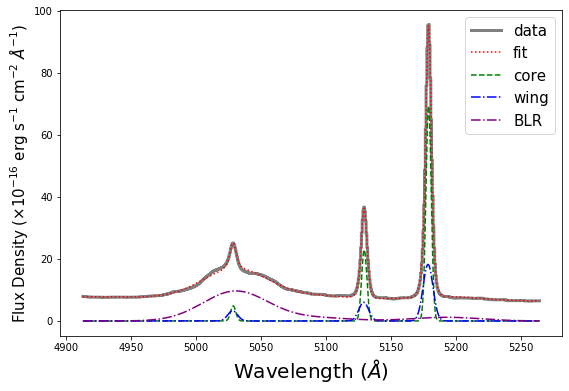

No handles with labels found to put in legend.


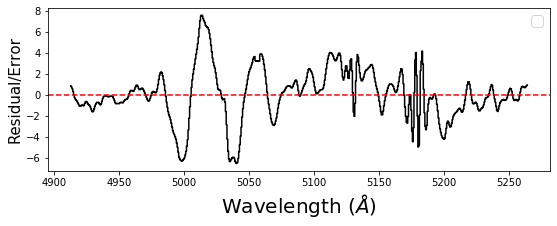

In [9]:
z = {"HE1310-1051":0.03427}

objs = z.keys()

broad2= {'HE1310-1051':False}

p_init= {'HE1310-1051':[4.865520407970427, 69.55902880176502, 10319.027136891007, 105.21884976426972,3.294095718298136, 18.238836373521526, 10293.043866323937, 219.82675085308708, 9.637885796086037, 1.193171701966462, 10433.45751305314, 1547.0505518889238, 0, 0, 10281.0, 1500.0, -4.096207729698785, 27.946376250642416]}

for obj in objs:
     spectroastrometric_script(obj,p_init[obj],z[obj],broad2[obj]) 


HE1338-1423
7.102607
[5.858301431486153, 50.32148012431247, 12392.753496477333, 125.29224092431753, 5.542217485050081, 38.02094641619908, 12405.539639375369, 272.3572951069911, 20.133453874248808, 3.3932543603340113, 12450.190987058219, 584.1212492437709, 12.674221149189231, 0.47192859670430803, 12590.128612481332, 1470.9543881641723, -6.154445555514343, 38.825757883045185, -12.786142898035905, 534.8891337863151, 41.704069959801785, 1239.6106912007747, 263.8687280514372, 433.5960479648578, 697.464776016295, 41.45430692595812] [5.82612336e-01 1.98055477e+00 1.10013295e+00 3.20402572e+00
 9.85453107e-01 2.05238249e+00 2.48660631e+00 5.14080660e+00
 4.68462415e-01 1.07081970e-01 3.61312125e+00 1.35468864e+01
 3.66782013e-01 1.24970071e-01 9.88257656e+00 1.89247612e+01
 1.73521218e-01 8.82454529e-01 3.39126187e+00 2.28663744e+00
 3.22232026e-03 9.18378828e+00 1.68544686e+01 1.56425408e+01
 1.98877249e+00 1.23823360e-03]


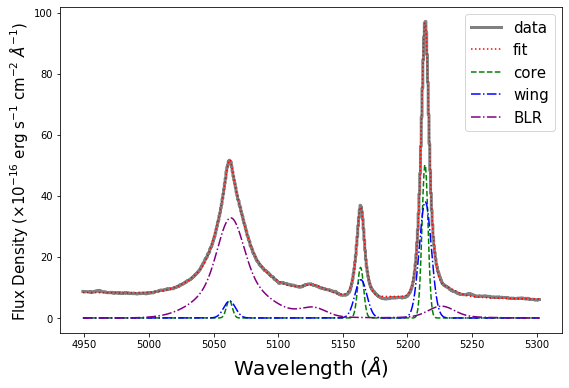

No handles with labels found to put in legend.


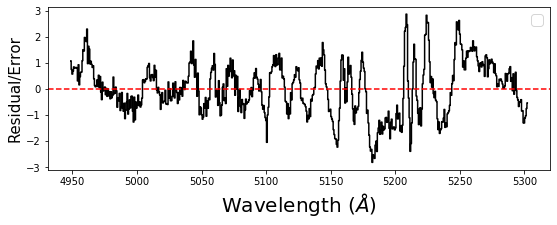

In [12]:
z = {"HE1338-1423":0.04179}

objs = z.keys()

broad2= {'HE1338-1423':True}

p_init= {'HE1338-1423':[5.858330879783606, 50.3217056220278, 12392.75312209992, 125.29268024543057, 5.542213537859763, 38.02069813291083, 12405.540334328602, 272.35783869735815, 20.133452995739237, 3.3932428856782635, 12450.191027525314, 584.122061583845, 12.674196923508559, 0.4719313200531102, 12590.128730257327, 1470.9555603015356, -6.154447751880857, 38.82576829120517]}

for obj in objs:
     spectroastrometric_script(obj,p_init[obj],z[obj],broad2[obj]) 